# Setting up the environment

## Importing relevant libraries

In [1]:
#__future__ to bring features from newer versions of Python 
# from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import string
from string import digits
import re
import time
import numpy as np
import pandas as pd
import collections
import unicodedata

import os

from bert import BertModelLayer
from bert.loader import StockBertConfig, load_stock_weights

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
tf.config.list_physical_devices('GPU')
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: Metal device set to: Apple M1
 True


2022-08-24 00:05:16.559618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-24 00:05:16.559716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Cleaning the data

In [3]:
#reading data from NLD-ENG translation dataset
with open('nld-eng/nld.txt','r') as f:
  data = f.read()

In [4]:
#removing trailing and leading characters
#creating list of word translations by splitting on new line
uncleaned_data_list = data.strip().split('\n')
len(uncleaned_data_list)

68954

In [5]:
print(uncleaned_data_list[4])

Hi.	Hai!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #6117420 (Raizin)


In [6]:
for word in uncleaned_data_list:
    print(word.split('\t'))
    break

['Go.', 'Lopen!', 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)']


In [7]:
for word in uncleaned_data_list:
    print(word.split('\t')[:-1])
    break

['Go.', 'Lopen!']


In [8]:
#separating english and dutch words 
eng_word = []
nld_word = []
for word in uncleaned_data_list:
    eng_word.append(word.split('\t')[:-1][0])
    nld_word.append(word.split('\t')[:-1][1])

In [9]:
#creating pandas df with english words and their dutch equivalents
data = pd.DataFrame(columns=['English','Dutch'])
data['English'] = eng_word
data['Dutch'] = nld_word

In [10]:
data.to_csv('data.csv', index=False)

In [11]:
data = pd.read_csv('data.csv')
data.head()

,English,Dutch
0,Go.,Lopen!
1,Go.,Vooruit.
2,Hi.,Hoi.
3,Hi.,Hé!
4,Hi.,Hai!


In [12]:
eng_word[-1]

"If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker."

In [13]:
#80% of data used for training, and 20% for testing the models
# Shuffle dataset 
shuffle_df = data.sample(frac=1)

# Define a size for train set 
train_size = int(0.8 * len(data))

# Split dataset 
train_ex = shuffle_df[:train_size]
test_ex = shuffle_df[train_size:]

In [14]:
eng_train = train_ex['English'].values
nld_train = train_ex['Dutch'].values
eng_test = test_ex['English'].values
nld_test = test_ex['Dutch'].values

In [15]:
#we get the slices of the arrays as objects by using tf.data.Dataset.from_tensor_slices() 
train_ex = tf.data.Dataset.from_tensor_slices((eng_train,nld_train))
test_ex = tf.data.Dataset.from_tensor_slices((eng_test,nld_test))

2022-08-24 00:05:16.805982: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-24 00:05:16.806001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
#tf.compat.as_text() converts any string-like python input types to unicode.
for en, nld in train_ex.take(1):
  print(tf.compat.as_text(en.numpy()))
  print(tf.compat.as_text(nld.numpy()))

Let's go out.
Laten we uitgaan.


# Preprocessing and Tokenization

In [17]:
def to_unicode(text):
    #strings are stored as unicode in Python 3.0 and above
    if isinstance(text,str):
        return text
    #conversion of bytes to unicode
    elif isinstance(text,bytes):
        return text.decode('utf-8','ignore')
    else:
        raise ValueError("Unsupported string type: %s" % (type(text)))

In [18]:
#load vocab file into a dictionary
def load_dict(vocab_file):
    vocab = collections.OrderedDict()
    index = 0
    with open(vocab_file, "r") as reader:
        while True:
            token = to_unicode(reader.readline())
            if not token:
                break
            token = token.strip()
            vocab[token] = index
            index += 1
    return vocab

In [19]:
# removes whitespace from text and returns tokens
def remove_whitespace(text):
    text = text.strip()
    if not text:
        return []
    token = text.split()
    return token

In [20]:
def convert_vocab(vocab,items):
    output = []
    for item in items:
        output.append(vocab[item])
    return output

In [21]:
# for end-to-end tokenization
class FullTokenizer(object):
    def __init__(self, vocab_file, do_lower_case=True):
        self.vocab = load_dict(vocab_file)
        # map IDs to tokens
        self.invert_vocab = {v: k for k, v in self.vocab.items()}
        # basic tokenizer to break text into tokens based on whitespace
        self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
        # Wordpiece tokenizer to generate sub-tokens out of the tokens from BasicTokenizer
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)
    
    # uses Wordpiece to tokenize tokens generated by the BasicTokenizer
    def tokenize(self, text):
        split_tokens = []
        for token in self.basic_tokenizer.tokenize(text):
            for sub_token in self.wordpiece_tokenizer.tokenize(token):
                split_tokens.append(sub_token)
        return split_tokens
    
    # after being provided the tokens, outputs the IDs of the tokens
    def convert_tokens_to_ids(self, tokens):
        return convert_vocab(self.vocab, tokens)
    
    # after being provided the IDs, outputs the tokens mapped to the IDs
    def convert_ids_to_tokens(self, ids):
        return convert_vocab(self.invert_vocab, ids)

In [22]:
# tokenizes based on whitespace and punctuation, also lower-cases the tokens
class BasicTokenizer(object):
    
    # whether or not to lower-case the tokens
    def __init__(self, do_lower_case=True):
        self.do_lower_case = do_lower_case

    # tokenizes the text
    def tokenize(self, text):
        text = to_unicode(text)
        text = self.text_clean(text)
        text = self._tokenize_chinese_chars(text)

        orig_tokens = remove_whitespace(text)
        split_tokens = []
        for token in orig_tokens:
            if self.do_lower_case:
                token = token.lower()
                token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token))

        output_tokens = remove_whitespace(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text):
        """Splits punctuation on a piece of text."""
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]

    # adds whitespace around CJK characters
    def _tokenize_chinese_chars(self, text):
        output = []
        for char in text:
            # returns unicode for the codepoint
            cp = ord(char)
            if self._is_chinese_char(cp):
                output.append(" ")
                output.append(char)
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)
    
    # checks if codepoint is a CJK character
    def _is_chinese_char(self, cp):
        if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
                (cp >= 0x3400 and cp <= 0x4DBF) or  #
                (cp >= 0x20000 and cp <= 0x2A6DF) or  #
                (cp >= 0x2A700 and cp <= 0x2B73F) or  #
                (cp >= 0x2B740 and cp <= 0x2B81F) or  #
                (cp >= 0x2B820 and cp <= 0x2CEAF) or
                (cp >= 0xF900 and cp <= 0xFAFF) or  #
                (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
            return True

        return False
    
    # removes invalid characters and cleans up whitespaces
    def text_clean(self, text):
        output = []
        for char in text:
            # get unicode of character
            cp = ord(char)
            # check if character is NULL, replacement character, or control character
            if cp == 0 or cp == 0xfffd or _is_control(char):
                continue
            # check if character is a whitespace character
            if _is_whitespace(char):
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)


In [23]:
# tokenization based on Wordpiece
class WordpieceTokenizer(object):

    def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=200):
        self.vocab = vocab
        # unk_token represents an unknown word that is not present in the vocabulary
        self.unk_token = unk_token
        self.max_input_chars_per_word = max_input_chars_per_word
    
    # tokenizes text into word pieces
    def tokenize(self, text):
        """
        A very similar algorithm to BPE.
        BPE is a compression algorithm which replaces consecutive bytes of data with a byte that does not occur
        in the data. It does so by mapping individual characters of text to their frequency, inculding an EOW token.
        In each further iteration, the most frequent pairing or characters or group of characters from the table
        is merged together until token limit or iteration limit is reached.
        
        In WordPiece tokenization, the only difference is how the pairing to be merged is selected. At each 
        iterative step, WordPiece chooses a symbol pair which will result in the largest increase in likelihood 
        upon merging. P(AB)/[P(A)*P(B)]
        The time complexity is O(K²) where K is the number of current word units in the table.
        While we use probability, the algorithm is still greedy. For a probabilistic approach, the unigram tokenizer
        is used.
        
        For example:
          input = "unaffable"
          output = ["un", "##aff", "##able"]
        Here '##' indicates that the token is a suffix, and should be used in that context. 
    
        Args:
          text: A single token or whitespace separated tokens. This should have
            already been passed through `BasicTokenizer.
    
        Returns:
          A list of wordpiece tokens.
        """

        text = to_unicode(text)

        output_tokens = []
        for token in remove_whitespace(text):
            # splits token into chars
            chars = list(token)
            if len(chars) > self.max_input_chars_per_word:
                output_tokens.append(self.unk_token)
                continue

            is_bad = False
            start = 0
            sub_tokens = []
            while start < len(chars):
                end = len(chars)
                cur_substr = None
                # finds longest substring from start of remaining word which is in vocab
                while start < end:
                    substr = "".join(chars[start:end])
                    if start > 0:
                        substr = "##" + substr
                    if substr in self.vocab:
                        cur_substr = substr
                        break
                    end -= 1
                # if no such substring, the token is not in vocab
                if cur_substr is None:
                    is_bad = True
                    break
                sub_tokens.append(cur_substr)
                # find next substring
                start = end

            if is_bad:
                output_tokens.append(self.unk_token)
            else:
                output_tokens.extend(sub_tokens)
        return output_tokens

In [24]:
# checks if char is whitespace 
def _is_whitespace(char):
    # \t, \n, and \r are technically controll characters but we treat them
    # as whitespace since they are generally considered as such.
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    # returns category of char
    cat = unicodedata.category(char)
    # char of category space separator
    if cat == "Zs":
        return True
    return False


def _is_control(char):
    # These are technically control characters but we count them as whitespace
    # characters.
    if char == "\t" or char == "\n" or char == "\r":
        return False
    # returns category of char
    cat = unicodedata.category(char)
    # char of category control, format, private use, or surrogate
    if cat.startswith("C"):
        return True
    return False

# checks if char is a punctuation
def _is_punctuation(char):
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    # returns category of char
    cat = unicodedata.category(char)
    # char of category punctuation
    if cat.startswith("P"):
        return True
    return False

## Create a custom subwords tokenizer from the training dataset for the decoder.
The encoder uses BERT Tokenizer

In [25]:
import os
vocab_file = 'vocab_nld'
# The vocabulary is "trained" on a corpus and all wordpieces are stored in a vocabulary file
if os.path.isfile(vocab_file + '.subwords'):
    # Invertible TextEncoder using word pieces with a byte-level fallback
    tokenizer_nld = tfds.deprecated.text.SubwordTextEncoder.load_from_file(vocab_file)
else: 
    # if vocab file not stored, build it
    tokenizer_nld = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (nld_train), target_vocab_size=2 ** 15)
    tokenizer_nld.save_to_file('vocab_nld')

sample_string = 'Mooie kale man.'
tokenized_string = tokenizer_nld.encode(sample_string)
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_nld.decode([ts])))

17285 ----> Mooie 
14012 ----> kale 
580 ----> man
18097 ----> .


In [26]:
# english tokenizer using the custom FullTokenizer
tokenizer_en = FullTokenizer(
    vocab_file= 'vocab_en.txt',
    do_lower_case=True)

test_tokens = tokenizer_en.tokenize("serendipity")
# [CLS] token is used to indicate the task we want BERT to perform is next-sentence prediction, and not mask
# word prediction. We can think about the output of [CLS] as a probability. Used to oraganize tasks as [CLS]
# and [MASK]. [SEP] is also used for next-sentence predication tasks. It helps the model distinguish one 
# sentence from the next.
test_ids = tokenizer_en.convert_tokens_to_ids(['[CLS]'] + test_tokens + ['[SEP]'])
print(test_ids)
print(tokenizer_en.convert_ids_to_tokens(test_ids))

[101, 14262, 10497, 11514, 3012, 102]
['[CLS]', 'ser', '##end', '##ip', '##ity', '[SEP]']


In [27]:
MAX_SEQ_LENGTH = 50

def encode(en, nld, seq_length=MAX_SEQ_LENGTH):
    # converts Python input text to unicode
    tokens_en = tokenizer_en.tokenize(tf.compat.as_text(en.numpy()))
    lang1 = tokenizer_en.convert_tokens_to_ids(['[CLS]'] + tokens_en + ['[SEP]'])
    if len(lang1)<seq_length:
        # makes token list equal to length of seq_length
        lang1 = lang1 + list(np.zeros(seq_length - len(lang1), 'int32'))
    # lang2 is a list with first argument as size of vocab of Dutch tokenizer, followed by list of Dutch text converted
    # to integers, and again the last argument is the size of the vocab+1
    lang2 = [tokenizer_nld.vocab_size] + tokenizer_nld.encode(tf.compat.as_text(nld.numpy())) + [tokenizer_nld.vocab_size + 1]
    if len(lang2)<seq_length:
        lang2 = lang2 + list(np.zeros(seq_length - len(lang2), 'int32'))
    return lang1, lang2

In [28]:
# used to convert shape and type of output from tf.string to tf.int32, makes shape(None,) required for future 
# functions
def tf_encode(en, nld):
    # tf.py_function makes it possible to express control flow using Python constructs (if, while, for, etc.), 
    # instead of TensorFlow control flow constructs (tf.cond, tf.while_loop) for the function used in the argument
    # tf.py_function(func, inp, Tout, name=None)
    result_en, result_nld = tf.py_function(encode, [en, nld], [tf.int32, tf.int32])
    # sets particular shape to the objects
    result_en.set_shape([None])
    result_nld.set_shape([None])
    return result_en, result_nld

In [29]:
# checks if both english and dutch seentences are less than max_length
def filter_max_length(x, y, max_length=MAX_SEQ_LENGTH):
    # element-wise AND of its arguments
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [30]:
BUFFER_SIZE = 40000
BATCH_SIZE = 64

# applies tf_encode, filter_max_length functions to entire dataset
train_dataset = train_ex.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()

# maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]), drop_remainder=True)
# creates a Dataset that prefetches elements from this dataset. This allows later elements to 
# be prepared while the current element is being processed. 
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_ex.map(
    lambda en, nld: tf.py_function(encode, [en, nld], [tf.int32, tf.int32]))
test_dataset = test_dataset.filter(filter_max_length)
test_dataset = test_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))

# Attention

## Positional Encoding
The positional encoding vector is added to the embedding vector. Embeddings represent a token in a 
d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do 
not encode the relative position of words in a sentence. So after adding the positional encoding, words will
be closer to each other based on the similarity of their meaning and their position in the sentence, in the 
d-dimensional space.
The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [31]:
# angles to which sin and cos will be applied
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [32]:
# calculates the positional encoding vector
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i, start at 0, skip 2
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1, start at 1, skip 2
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [33]:
def create_padding_mask(seq):
    #tf.cast casts a tensor to a new type
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions so that we can add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [34]:
def create_look_ahead_mask(size):
    # Copy a tensor setting everything outside a central band in each innermost matrix to zero
    # The indicator function in_band(m, n) = (num_lower < 0 || (m-n) <= num_lower)) 
    # && (num_upper < 0 || (n-m) <= num_upper)
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0) # 1 - (lower triangle of matrix)
    # lower triangle is not masked
    return mask  # (seq_len, seq_len)

## Scaled dot product attention
$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

In [35]:
# the attention values decide the amount of importance given to the keys for each query.
# The output represents the multiplication of the attention weights and the V (value) 
# vector. This ensures that the tokens we want to focus on are kept as-is and the 
# irrelevant tokens are flushed out.
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  
    # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## Multi-Head-Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers.
*    Scaled dot-product attention.
*    Final linear layer.

In [36]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

## Point wise feed forward network

In [37]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Encoder
Use bert as encoder. The output shape is (batch_size, input_seq_len, d_model).

In [38]:
# using the bert_config.json from a pre-trained google model
def build_encoder(config_file):
    with tf.io.gfile.GFile(config_file, "r") as reader:
        stock_params = StockBertConfig.from_json_string(reader.read())
        bert_params = stock_params.to_bert_model_layer_params()

    return BertModelLayer.from_params(bert_params, name="bert")

# Decoder
Each decoder layer consists of sublayers:

1. Masked multi-head attention (with look ahead mask and padding mask)

2. Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer

3. Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

In [39]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        # call function of MHA (v,k,q,mask)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        # output of sublayer 1
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [40]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()

    # number of features expected in input
    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Transformer
A transformer consists of the encoder, decoder, and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.


In [41]:
class Config(object):
  def __init__(self, num_layers, d_model, dff, num_heads):
    self.num_layers = num_layers
    self.d_model = d_model
    self.dff = dff
    self.num_heads= num_heads

In [42]:
from bert.loader import map_to_stock_variable_name

class Transformer(tf.keras.Model):
    def __init__(self, config,
               target_vocab_size, 
               bert_config_file,
               bert_training=False, 
               rate=0.1,
               name='transformer'):
      super(Transformer, self).__init__(name=name)

      self.encoder = build_encoder(config_file=bert_config_file)
      self.encoder.trainable = bert_training

      self.decoder = Decoder(num_layers=config.num_layers, d_model=config.d_model,
                           num_heads=config.num_heads, dff=config.dff,
                           target_vocab_size=target_vocab_size, rate=rate)

      self.final_layer = tf.keras.layers.Dense(target_vocab_size)


    def load_stock_weights(self, bert: BertModelLayer, ckpt_file):
      assert isinstance(bert, BertModelLayer), "Expecting a BertModelLayer instance as first argument"
      assert tf.compat.v1.train.checkpoint_exists(ckpt_file), "Checkpoint does not exist: {}".format(ckpt_file)
      # returns CheckpointReader for checkpoint found in ckpt_dir_or_file.  
      ckpt_reader = tf.train.load_checkpoint(ckpt_file)

      bert_prefix = 'transformer/bert'

      weights = []
      for weight in bert.weights:
          stock_name = map_to_stock_variable_name(weight.name, bert_prefix)
          if ckpt_reader.has_tensor(stock_name):
              value = ckpt_reader.get_tensor(stock_name)
              weights.append(value)
          else:
              raise ValueError("No value for:[{}], i.e.:[{}] in:[{}]".format(weight.name, stock_name, ckpt_file))
      bert.set_weights(weights)
      print("Done loading {} BERT weights from: {} into {} (prefix:{})".format(
          len(weights), ckpt_file, bert, bert_prefix))

    def restore_encoder(self, bert_ckpt_file):
      # loading the original pre-trained weights into the BERT layer:
      self.load_stock_weights(self.encoder, bert_ckpt_file)

    def call(self, inp, tar, training, look_ahead_mask, dec_padding_mask):
      enc_output = self.encoder(inp, training=self.encoder.trainable)  # (batch_size, inp_seq_len, d_model)

      # dec_output.shape == (batch_size, tar_seq_len, d_model)
      dec_output, attention_weights = self.decoder(
          tar, enc_output, training, look_ahead_mask, dec_padding_mask)

      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

      return final_output, attention_weights

# Fine-tuning model and hyperparameters

In [43]:
target_vocab_size = tokenizer_nld.vocab_size + 2
dropout_rate = 0.15
config = Config(num_layers=6, d_model=512, dff=1024, num_heads=8)

In [44]:
MODEL_DIR = "uncased_L-12_H-768_A-12"
bert_config_file = os.path.join(MODEL_DIR, "bert_config.json")
bert_ckpt_file = os.path.join(MODEL_DIR, 'bert_model.ckpt')
MAX_TOKENS = 128
transformer = Transformer(config=config,
                          target_vocab_size=target_vocab_size,
                          bert_config_file=bert_config_file)
  
inp = tf.random.uniform((BATCH_SIZE, MAX_SEQ_LENGTH))
tar_inp = tf.random.uniform((BATCH_SIZE, MAX_SEQ_LENGTH))
fn_out, _ = transformer(inp, tar_inp, 
                        True,
                        look_ahead_mask=None,
                        dec_padding_mask=None)
print(tar_inp.shape) # (batch_size, tar_seq_len) 
print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size) 

# init bert pre-trained weights
transformer.restore_encoder(bert_ckpt_file)

(64, 50)
(64, 50, 18309)
Instructions for updating:
Use standard file APIs to check for files with this prefix.
Done loading 196 BERT weights from: uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x1056ca040> (prefix:transformer/bert)


In [45]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BertModelLayer)        multiple                  108890112 
_________________________________________________________________
decoder (Decoder)            multiple                  29873664  
_________________________________________________________________
dense_60 (Dense)             multiple                  9392517   
Total params: 148,156,293
Trainable params: 39,266,181
Non-trainable params: 108,890,112
_________________________________________________________________


Using the Adam optimizer with a custom learning rate scheduler according to the formula in ['Attention is all you need'](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [46]:
# to modulate how the learning rate of your optimizer changes over time
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        # reciprocal of square root
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
learning_rate = CustomSchedule(config.d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

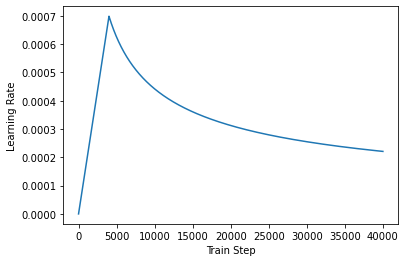

In [48]:
temp_learning_rate_schedule = CustomSchedule(config.d_model)
import matplotlib.pyplot as plt

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and Metrics
Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [49]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [50]:
def loss_function(real, pred):
    # performs logical NOT of real==0
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    # computes the sum of elements across dimensions of a tensor.
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [51]:
def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [52]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# Training and checkpointing
Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.

In [53]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. tar_real is that same input shifted by 1: At each location in tar_input, tar_real contains the next token that should be predicted.

Training uses teacher forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output, the model uses a look-ahead mask.

In [54]:
def create_masks(inp, tar):
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask, dec_padding_mask

In [55]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.
@tf.function
def train_st(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    # tf.GradientTape() records operations for automatic differentiation
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)


In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> dutch, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_st(inp, tar)

        if batch % 10 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1,
                                                            ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                        train_loss.result(),
                                                        train_accuracy.result()))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

# Evaluate

The following steps are used for evaluation:

Encode the input sentence using the english tokenizer (tokenizer_en). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.

The decoder input is the start token == tokenizer_nld.vocab_size.

Calculate the padding masks and the look ahead masks.

The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).

Select the last word and calculate the argmax of that.

Concatentate the predicted word to the decoder input as pass it to the decoder.

In this approach, the decoder predicts the next word based on the previous words it predicted.

In [56]:
def encode_en(en):
    seq_length = MAX_SEQ_LENGTH
    tokens_en = tokenizer_en.tokenize(en)
    lang1 = tokenizer_en.convert_tokens_to_ids(['[CLS]'] + tokens_en + ['[SEP]'])
    if len(lang1)<seq_length:
        # makes token list equal to length of seq_length
        lang1 = lang1 + list(np.zeros(seq_length - len(lang1), 'int32'))
    return lang1

In [57]:
def evaluate(transformer, inp_sentence):
    # normalize input sentence
    inp_sentence = encode_en(inp_sentence)
#     encoder_input = inp_sentence
    encoder_input = tf.expand_dims(inp_sentence, 0)
#     multiply = tf.constant([64])
#     encoder_input = tf.reshape(tf.tile(encoder_input, multiply), [ multiply[0], tf.shape(encoder_input)[0]])

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_nld.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_SEQ_LENGTH):
        combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, tokenizer_nld.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [58]:
def translate(transformer, sentence):
    result, attention_weights = evaluate(transformer, sentence)

    predicted_sentence = tokenizer_nld.decode([i for i in result
                                              if i < tokenizer_nld.vocab_size])

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

In [ ]:
translate(transformer, 'time to chase money.')

In [ ]:
translate(transformer, 'when it rains, it pours.')

In [ ]:
translate(transformer, 'you fumble the bag.')

In [ ]:
translate(transformer, 'we want happiness.')

In [ ]:
translate(transformer, "please don't kill my vibe.")

In [ ]:
translate(transformer, 'i am proud of you.')

In [ ]:
translate(transformer, 'plentiful')

# Save weights

In [59]:
transformer.save_weights('bert_nmt_ckpt')

In [60]:
new_transformer = Transformer(config=config,
                          target_vocab_size=target_vocab_size,
                          bert_config_file=bert_config_file)
  
fn_out, _ = new_transformer(inp, tar_inp, 
                        True,
                        look_ahead_mask=None,
                        dec_padding_mask=None)
new_transformer.load_weights('bert_nmt_ckpt')

In [ ]:
translate(new_transformer, 'go to a party every day.')

In [ ]:
translate(new_transformer, 'i dont like you, i love you.')

In [ ]:
translate(new_transformer, 'i drink a lot of water.')